# Visualization of Agent Movement in single scene

<br> ------------------------------------------------------------------------
<br> This Notebook visualizes the agent's motion patterns in a single 
<br> scene. 
<br> To execute this notebook it is required that the Lyft dataset already 
<br> has been preprocessed.
<br>
<br> tl2la
<br> Copyright (c) 2023 Andreas Weber. All Rights Reserved.
<br> ------------------------------------------------------------------------
<br> Modified from L5Kit (https://github.com/woven-planet/l5kit)
<br> Copyright (c) 2022 Woven by Toyota. All Rights Reserved.
<br> ------------------------------------------------------------------------


In [6]:
import matplotlib.pyplot as plt
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from l5kit.data.filter import filter_agents_by_frames

from src.dataset_operations.extended_map_api import ExtendedMapAPI
from src.common.helper import (filter_unique_labels, init_dataset,
                               get_pickled_dataset_index)
from src.dataset_operations.junction_dataset import JunctionDataset
from src.common.utils import (above_given_speed, above_given_track_length,
                              agent_on_branch,
                              on_lane_sequence,
                              get_agents_velocity_frame, get_ego_movement_frame,
                              calcualte_agent_acceleration,
                              merge_agent_lane_mapping_and_branch_frame,
                              calculate_tl_distance,
                              calculate_lead_vehicle)
from src.common.definitions import DATASET_TYPE

FIGSIZE = (16, 8)
LABELSIZE = 12
TITLESIZE = 14


warnings.simplefilter(action='ignore', category=FutureWarning) # ignore for dataframe append
warnings.simplefilter(action='ignore', category=UserWarning) # ignore for seaborn empty hue plot

In [3]:
# %% Load Dataset
cfg, dm, zarr_dataset = init_dataset("trainfull")
mapAPI = ExtendedMapAPI.from_config(dm, cfg)
junctionDataset = JunctionDataset(cfg, mapAPI, zarr_dataset)


In [4]:
scene_idx = 474

sample_scene = zarr_dataset.get_scene_dataset(scene_index=scene_idx)
sample_scene_frames = sample_scene.frames
sample_scene_agents = sample_scene.agents
agent_frames = filter_agents_by_frames(sample_scene_frames, sample_scene_agents)

dataset_idx = get_pickled_dataset_index(scene_idx, cfg)
agent_mapping_df = junctionDataset.get_agent_mapping(dataset_idx)
tl_mapping_df = junctionDataset.get_tl_mapping(dataset_idx)
extended_branch_df = junctionDataset.get_branch_dataset(DATASET_TYPE.EXTENDED)

# merge agent mapping and branch ids
agent_mapping_branch_df = merge_agent_lane_mapping_and_branch_frame(agent_mapping_df, extended_branch_df)

/lhome/andrwe/Programming/AFL_6Sem/venv_tl2la/lib/python3.8/site-packages/l5kit/data/zarr_dataset.py:213: RuntimeWarning: zarr dataset path should end with .zarr (for now). Open will fail for this dataset!
  dataset = ChunkedDataset("")


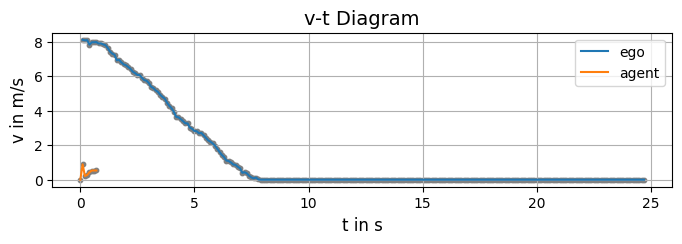

In [13]:
# Get Velocity and Acceleration
ego_movement_df = get_ego_movement_frame(sample_scene_frames["ego_translation"],
                                         scene_idx,
                                         len(sample_scene_frames)
                                         )
agent_movement_df = get_agents_velocity_frame(agent_frames, scene_idx)
agent_movement_df["a"] = calcualte_agent_acceleration(agent_movement_df)


movement_df = pd.concat([ego_movement_df, agent_movement_df], ignore_index=True)


motion_df = agent_mapping_branch_df.merge(movement_df.set_index('scene_idx', 'frame_idx', 'agent_id'), on=['scene_idx', 'frame_idx', 'agent_id'], how='outer').copy()
motion_df.dropna(subset=["lane_id", "centroid", "v", "a"], inplace=True)
motion_df["lane_sequence_id"] = motion_df["lane_sequence_id"].fillna(-1)


motion_df = calculate_tl_distance(mapAPI, motion_df)
motion_df = calculate_lead_vehicle(motion_df)


# Plot Velocities of ego and agent 3 (sucessor of ego vehicle)
ego_agent = movement_df[movement_df["agent_id"] == 0]
ego_successor = movement_df[movement_df["agent_id"] == 3]

fig = plt.figure(figsize=(FIGSIZE[0]/2, FIGSIZE[1]/4))
plt.rc('axes', labelsize=LABELSIZE)
plt.rc('axes', titlesize=TITLESIZE)

# plot ego
plt.scatter(ego_agent["time"], ego_agent["v"], c="grey", s=10)
plt.plot(ego_agent["time"], ego_agent["v"], label="ego")

plt.plot(ego_successor["time"], ego_successor["v"], label="agent")
plt.scatter(ego_successor["time"], ego_successor["v"], c="grey", s=10)

plt.title("v-t Diagram")
plt.xlabel("t in s")
plt.ylabel("v in m/s")

plt.grid()
plt.legend()
plt.show()


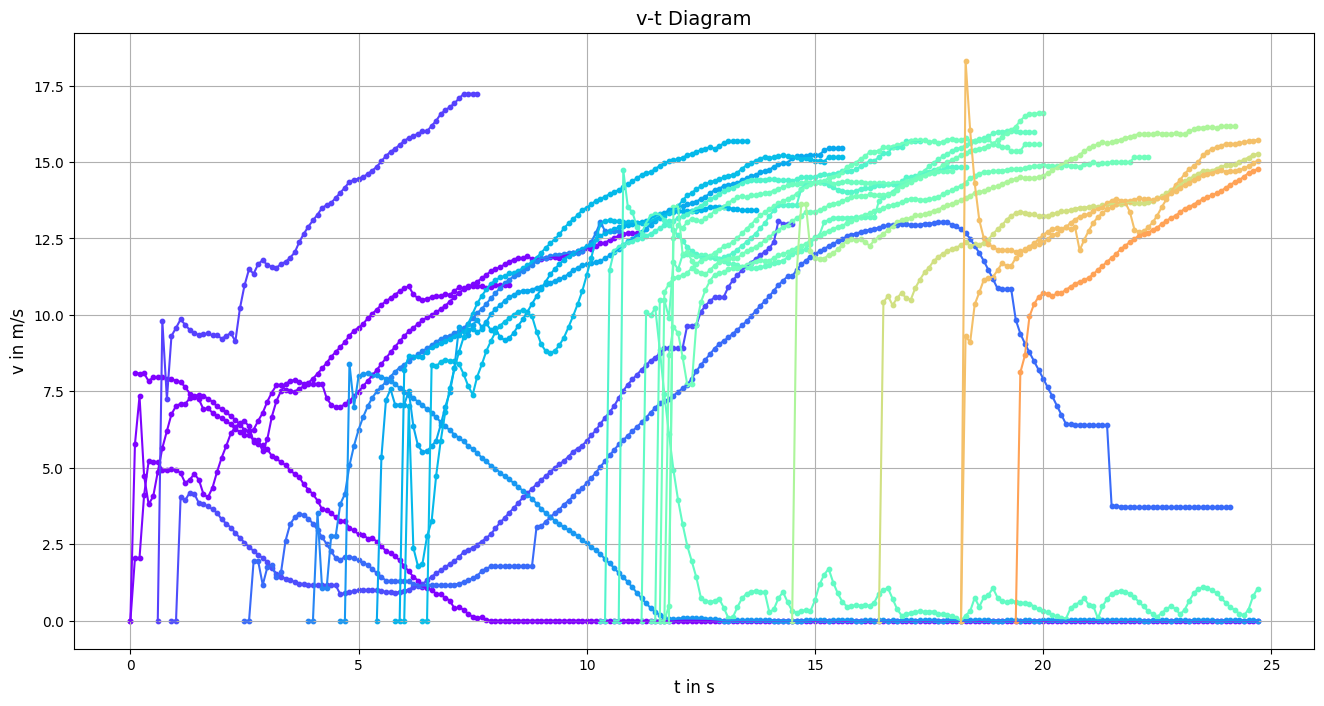

In [8]:
# Velocities of all agents in the scene
agent_ids = movement_df["agent_id"].unique().tolist()
colors = iter(plt.cm.rainbow(np.linspace(0, 1, len(agent_ids))))

plt.figure(figsize=FIGSIZE)
plt.rc('axes', labelsize=LABELSIZE)
plt.rc('axes', titlesize=TITLESIZE)

for agent_id in agent_ids:
    col = next(colors)
    current_agent = movement_df[movement_df["agent_id"] == agent_id]

    # filter
    filter_criteria = True
    filter_criteria = above_given_track_length(current_agent, 5)
    filter_criteria = filter_criteria and above_given_speed(current_agent, 8)

    if filter_criteria:
        plt.scatter(current_agent["time"], current_agent["v"], color=col, s=10)
        plt.plot(current_agent["time"], current_agent["v"], color=col)


plt.title("v-t Diagram")
plt.xlabel("t in s")
plt.ylabel("v in m/s")

plt.grid()
# plt.savefig(f"./res/analysis/algorithm/v-t_diagram_total_scene{scene_idx}.png")
plt.show()

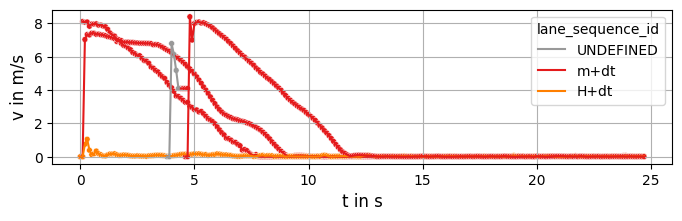

In [10]:
# Velocities of all agents in the scene but on the same branch as ego
selected_branch_id = "WOuys"
agent_ids = movement_df["agent_id"].unique().tolist()
agent_mapping_scene_df = agent_mapping_branch_df[agent_mapping_branch_df["scene_idx"] == scene_idx]

mapped_agent_on_branch = agent_mapping_scene_df[agent_mapping_scene_df["branch_id"]
                                                == selected_branch_id]
mapped_agent_on_branch = mapped_agent_on_branch[~mapped_agent_on_branch["lane_id"].isin(
    ["OLcZ", "TbHk", "ybHk", "v7zs", "o7Zz"])]  # exclude specific lanes

unique_lane_idx = mapped_agent_on_branch["sequence_head_lane_id"].unique()

merged_df = mapped_agent_on_branch.merge(
    movement_df.set_index(["scene_idx", "frame_idx", "agent_id"]), on=["scene_idx", "frame_idx", "agent_id"], how='outer')
merged_df["sequence_head_lane_id"] = merged_df["sequence_head_lane_id"].fillna(
    "UNDEFINED")

unique_agent_ids = merged_df["agent_id"].unique()
unique_lane_idx = merged_df["sequence_head_lane_id"].unique()

cmap = plt.get_cmap('Set1', 5)
rgb_mapper = {lane_idx: cmap(i) for lane_idx, i in zip(
    unique_lane_idx, np.linspace(0, 1, len(unique_lane_idx)))}


fig, ax = plt.subplots(figsize=(FIGSIZE[0]/2, FIGSIZE[1]/4))
plt.rc('axes', labelsize=LABELSIZE)
plt.rc('axes', titlesize=TITLESIZE)

for agent_id in unique_agent_ids:
    current_agent = merged_df[merged_df["agent_id"] == agent_id]
    if agent_on_branch(current_agent, selected_branch_id) and on_lane_sequence(current_agent):
        sns.scatterplot(x="time", y="v", hue=current_agent["sequence_head_lane_id"], palette=rgb_mapper, size=10, legend=False,
                        ax=ax, data=current_agent)
        sns.lineplot(x="time", y="v", hue=current_agent["sequence_head_lane_id"],
                     palette=rgb_mapper, legend=True, ax=ax, data=current_agent)


# plt.title(f"v-t Diagram of Scene {scene_idx}")
plt.xlabel("t in s")
plt.ylabel("v in m/s")

plt.grid()

handles, labels = filter_unique_labels(ax)
ax.legend(handles, labels, title="lane_sequence_id")

# plt.legend([f"agent_id: {agent_id}" for agent_id in agent_ids])
plt.savefig(
    f"./res/analysis/algorithm/v-t_diagram_total_scene{scene_idx}.png", bbox_inches="tight")
plt.show()

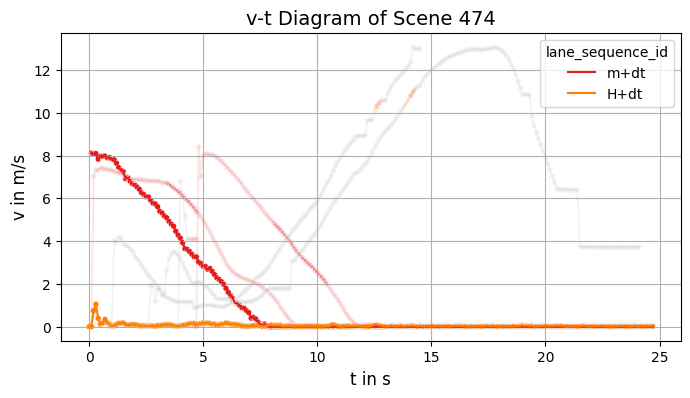

In [54]:
# Velocities of all agents in the scene + at the same branch as ego + lead vehicle visualization
selected_branch_id = "WOuys"
agent_ids = movement_df["agent_id"].unique().tolist()
agent_mapping_scene_df = agent_mapping_branch_df[agent_mapping_branch_df["scene_idx"] == scene_idx]

mapped_agent_on_branch = agent_mapping_scene_df[agent_mapping_scene_df["branch_id"]
                                                == selected_branch_id]

merged_df = mapped_agent_on_branch.merge(
    movement_df.set_index(["scene_idx", "frame_idx", "agent_id"]), on=["scene_idx", "frame_idx", "agent_id"], how='outer')
merged_df = calculate_tl_distance(mapAPI, merged_df)
merged_df = calculate_lead_vehicle(merged_df)

unique_agent_ids = merged_df["agent_id"].unique()
unique_lane_idx = merged_df["lane_sequence_id"].unique()

# use rgb_mapper from above
rgb_mapper_adjusted = {key: tuple(
    list(rgb_mapper[key][:3]) + [0.1]) for key in rgb_mapper.keys()}
fig, ax = plt.subplots(figsize=(FIGSIZE[0]/2, FIGSIZE[1]/2))
plt.rc('axes', labelsize=LABELSIZE)
plt.rc('axes', titlesize=TITLESIZE)

for agent_id in unique_agent_ids:
    current_agent = merged_df[merged_df["agent_id"] == agent_id].copy()
    current_agent["sequence_head_lane_id"].fillna("UNDEFINED", inplace=True)
    current_lead_agent = current_agent[current_agent["is_lead"] == True]
    if agent_on_branch(current_agent, selected_branch_id) and on_lane_sequence(current_agent):
        sns.scatterplot(x="time", y="v", hue=current_agent["sequence_head_lane_id"], palette=rgb_mapper_adjusted, size=10, legend=False,
                        ax=ax, data=current_agent)
        sns.lineplot(x="time", y="v", hue=current_agent["sequence_head_lane_id"],
                    palette=rgb_mapper_adjusted, legend=False, ax=ax, data=current_agent)
        sns.scatterplot(x="time", y="v", hue=current_lead_agent["sequence_head_lane_id"], palette=rgb_mapper, size=10, legend=False,
                        ax=ax, data=current_lead_agent)
        sns.lineplot(x="time", y="v", hue=current_lead_agent["sequence_head_lane_id"],
                    palette=rgb_mapper, legend=True, ax=ax, data=current_lead_agent)
        


plt.title(f"v-t Diagram of Scene {scene_idx}")
plt.xlabel("t in s")
plt.ylabel("v in m/s")

plt.grid()

handles, labels = filter_unique_labels(ax)
ax.legend(handles, labels, title="lane_sequence_id")
plt.show()


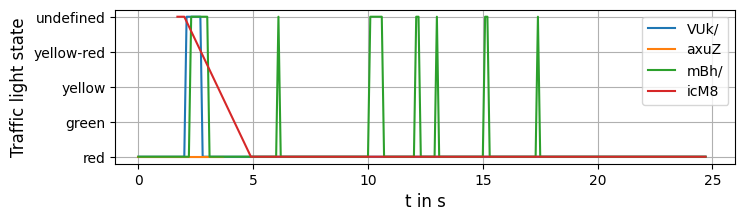

In [55]:
# Visualize Traffic Light Status Change
tl_mapping_scene_df = tl_mapping_df[tl_mapping_df["scene_idx"] == scene_idx].copy()
velocity_ego_df = movement_df[movement_df["agent_id"] == 0]

ADJ_FIGSIZE = (FIGSIZE[0]/2, FIGSIZE[1]/4)  # reduce height
fig, ax = plt.subplots(figsize=ADJ_FIGSIZE)
plt.rc('axes', labelsize=LABELSIZE)
plt.rc('axes', titlesize=TITLESIZE)

traffic_light_ids = tl_mapping_scene_df["tl_id"].unique()
for tl_id in traffic_light_ids:
    current_tl = tl_mapping_scene_df[tl_mapping_scene_df["tl_id"] == tl_id]
    current_tl_mapping_df = tl_mapping_scene_df[tl_mapping_scene_df["tl_id"] == tl_id]
    merged_df = pd.merge(velocity_ego_df, current_tl_mapping_df, on=[
                         "frame_idx"], how="outer")

    sns.lineplot(x="time", y="tl_status", legend=True,
                 ax=ax, data=merged_df, label=tl_id)
# plt.title("Tl-Status")
plt.xlabel("t in s")
plt.ylabel("Traffic light state")
plt.yticks([0, 1, 2, 3, 4], ["red", "green",
           "yellow", "yellow-red", "undefined"])
ax.set_xlim(-1, 26)
plt.grid()

plt.savefig(f"./res/analysis/algorithm/tl_status-t_diagram_total_scene{scene_idx}.png", bbox_inches="tight")
plt.show()

Traffic light signals are not stable and often occlued. This produces a flickering singal that can be hard to interprete.
It can be beneficial to filter out flickering and uninterpretable signals. This is done by interpreting a traffic light scene state for every traffic light in the preprocessing notebook.